In [19]:
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# xgboost
import xgboost as xgb_
from xgboost import plot_importance
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive # gdrive 연동
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Disease # 이진 분류 Data

df2 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/aiffel_data/Hackerton_2/data_over_sampling.csv', encoding='cp949') # upsampling 안된 것!
df2

,SEX,BTH_G,SBP,DBP,FBS,BMI,Dis
0,1,1,116,78,94,16.6,0
1,1,1,100,60,79,22.3,0
2,1,1,100,60,87,21.9,0
3,1,1,111,70,72,20.2,0
4,1,1,120,80,98,20.0,0
...,...,...,...,...,...,...,...
1481319,0,25,120,80,78,27.9,1
1481320,0,27,150,74,133,32.0,1
1481321,1,25,120,70,118,26.9,1
1481322,0,20,136,68,93,21.5,1


In [17]:
# feature와 target 분리(설명변수 및 목표변수 분리)
x = df2.drop(['Dis'], axis=1) # df[df.columns.difference(['target'])]
y = np.array(df2['Dis']) # y = df['target']


x_up_train,x_up_test,y_up_train,y_up_test=train_test_split(x,y,test_size=0.99, random_state = 42) # 기본 0.25
x_up_train,x_up_val,y_up_train,y_up_val=train_test_split(x,y,test_size=0.99, random_state = 42) # val 나누기

# # 표준 스케일러(평균 0, 분산 1)
# scaler = StandardScaler()
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_up_train = sc.fit_transform(x_up_train)
x_up_test = sc.transform(x_up_test)


# train_data 100만개, 10:3 ratio (training, test)
print(x_up_train.shape)
print(y_up_train.shape)
print(x_up_val.shape)
print(y_up_val.shape)
print(x_up_test.shape)
print(y_up_test.shape)

(14813, 6)
(14813,)
(1466511, 6)
(1466511,)
(1466511, 6)
(1466511,)


In [ ]:
# grid search 시간이 너무 많이 걸려 train data 

In [20]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb_.DMatrix(data=x_up_train, label = y_up_train)
dtest = xgb_.DMatrix(data=x_up_test, label=y_up_test)

In [21]:
xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
xgb.fit(x_up_train, y_up_train)
xgb_predict = xgb.predict(x_up_test)

In [22]:
xgb_param_grid = {
    'n_estimators' : [100, 200, 400, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
}

xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="accuracy", n_jobs= -1, verbose = 1)
xgb_grid.fit(x_up_train, y_up_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=XGBClassifier(max_depth=4, n_estimators=500), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [100, 200, 400, 600]},
             scoring='accuracy', verbose=1)

In [23]:
print("최고 평균 정확도 : {0:.4f}".format(xgb_grid.best_score_))
print("최고의 파라미터 : ", xgb_grid.best_params_)

최고 평균 정확도 : 0.7921
최고의 파라미터 :  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600}


In [26]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 4,
         'learning_rate' : 0.01, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

num_rounds = 600 # n_estimators와 같음

early_stopping_rounds 파라미터 : 조기 중단을 위한 라운드를 설정합니다.
조기 중단 기능 수행을 위해서는 반드시 eval_set과 eval_metric이 함께 설정되어야 합니다.

eval_set : 성능평가를 위한 평가용 데이터 세트를 설정
eval_metric : 평가 세트에 적용할 성능 평가 방법
(반복마다 eval_set으로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류를 측정)
train() 함수를 호출하면 xgboost가 반복 시마다 evals에 표시된 데이터 세트에 대해 평가 지표를 출력합니다.
그 후 학습이 완료된 모델 객체를 반환합니다.

In [27]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb_.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-logloss:0.689318	eval-logloss:0.688103
[1]	train-logloss:0.685578	eval-logloss:0.687506
[2]	train-logloss:0.681858	eval-logloss:0.684667
[3]	train-logloss:0.678289	eval-logloss:0.683876
[4]	train-logloss:0.674736	eval-logloss:0.673393
[5]	train-logloss:0.671247	eval-logloss:0.670964
[6]	train-logloss:0.66787	eval-logloss:0.66768
[7]	train-logloss:0.66451	eval-logloss:0.663706
[8]	train-logloss:0.661202	eval-logloss:0.661744
[9]	train-logloss:0.657955	eval-logloss:0.659674
[10]	train-logloss:0.654768	eval-logloss:0.655341
[11]	train-logloss:0.65169	eval-logloss:0.654946
[12]	train-logloss:0.648594	eval-logloss:0.645609
[13]	train-logloss:0.645611	eval-logloss:0.64437
[14]	train-logloss:0.642638	eval-logloss:0.643003
[15]	train-logloss:0.639696	eval-logloss:0.637673
[16]	train-logloss:0.636867	eval-logloss:0.6363
[17]	train-logloss:0.634071	eval-logloss:0.635753
[18]	train-logloss:0.631294	eval-logloss:0.6335
[19]	train-logloss:0.628599	eval-logloss:0.632557
[20]	train-logloss:

In [28]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.953 0.947 0.441 0.5   0.036 0.095 0.489 0.771 0.845 0.9  ]
예측값 10개만 표시:  [1, 1, 0, 1, 0, 0, 0, 1, 1, 1]


In [29]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [30]:
get_clf_eval(y_up_test, preds)

오차행렬:
 [[563296 169895]
 [133221 600099]]

정확도: 0.7933
정밀도: 0.7794
재현율: 0.8183
F1: 0.7984
AUC: 0.7933


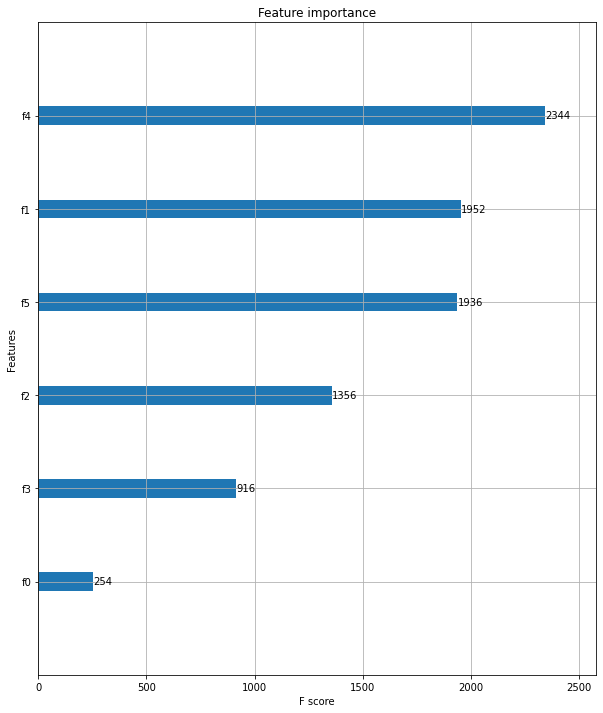

In [31]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

다만, xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수 없으므로
피처별로 f자 뒤에 순서를 붙여 X축에 피처들로 나열합니다.(f0는 첫번째 피처, f1는 두번째 피처를 의미)

제가 좋아하는 계절은? 봄
정답입니다.
